# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_PATH = "/content/drive/MyDrive/capuchin_project"
os.chdir(BASE_PATH)

Mounted at /content/drive


In [2]:
os.listdir("data")

['Parsed_Not_Capuchinbird_Clips',
 'Forest Recordings',
 'Parsed_Capuchinbird_Clips']

In [3]:
os.listdir("data/Parsed_Capuchinbird_Clips")[:5]

['XC114131-0.wav',
 'XC114131-1.wav',
 'XC114131-2.wav',
 'XC114131-3.wav',
 'XC114131-4.wav']

In [4]:
os.listdir("data/Parsed_Not_Capuchinbird_Clips")[:5]

['Crickets-chirping-10.wav',
 'Crickets-chirping-1.wav',
 'Crickets-chirping-0.wav',
 'Crickets-chirping-4.wav',
 'Crickets-chirping-2.wav']

In [5]:
os.listdir("data/Forest Recordings")[:5]

['recording_00.mp3',
 'recording_01.mp3',
 'recording_02.mp3',
 'recording_03.mp3',
 'recording_04.mp3']

In [6]:
!pip install tensorflow matplotlib scipy librosa

## 1.2 Load Dependencies

In [7]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import scipy.signal

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [8]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [9]:
def load_wav_16k_mono(filename):
    audio = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    def _scipy_resample_fn(audio_data, original_sample_rate, target_sample_rate):
        original_sample_rate = original_sample_rate.numpy().item()
        target_sample_rate = target_sample_rate.numpy().item()
        num_samples_target = int(len(audio_data) * target_sample_rate / original_sample_rate)
        resampled_audio = scipy.signal.resample(audio_data, num_samples_target)
        return resampled_audio.astype('float32')

    current_sample_rate = tf.cast(sample_rate, dtype=tf.float32)
    target_sample_rate = tf.constant(16000.0, dtype=tf.float32)

    resampled_wav = tf.py_function(
        _scipy_resample_fn,
        inp=[wav, current_sample_rate, target_sample_rate],
        Tout=tf.float32
    )
    resampled_wav.set_shape([None])
    return resampled_wav

## 2.3 Plot Wave

In [10]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
print(wave.shape)
print(nwave.shape)

(48000,)
(48927,)


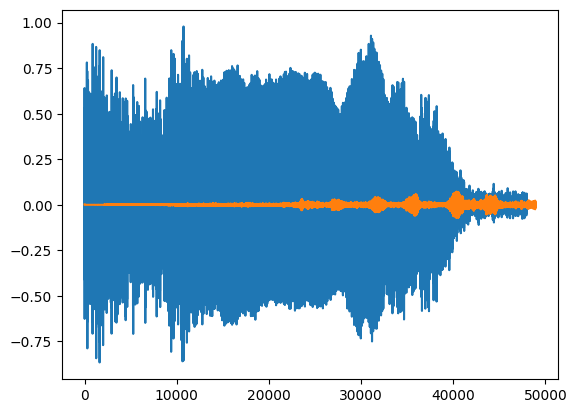

In [11]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [12]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [13]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
print("Positive:", len(list(pos)))
print("Negative:", len(list(neg)))

Positive: 217
Negative: 593


## 3.3 Add labels and Combine Positive and Negative Samples

In [14]:
positives = pos.map(lambda x: (x, 1))
negatives = neg.map(lambda x: (x, 0))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [15]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [16]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [17]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [18]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [19]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [20]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [21]:
spectrogram, label = preprocess(filepath, label)

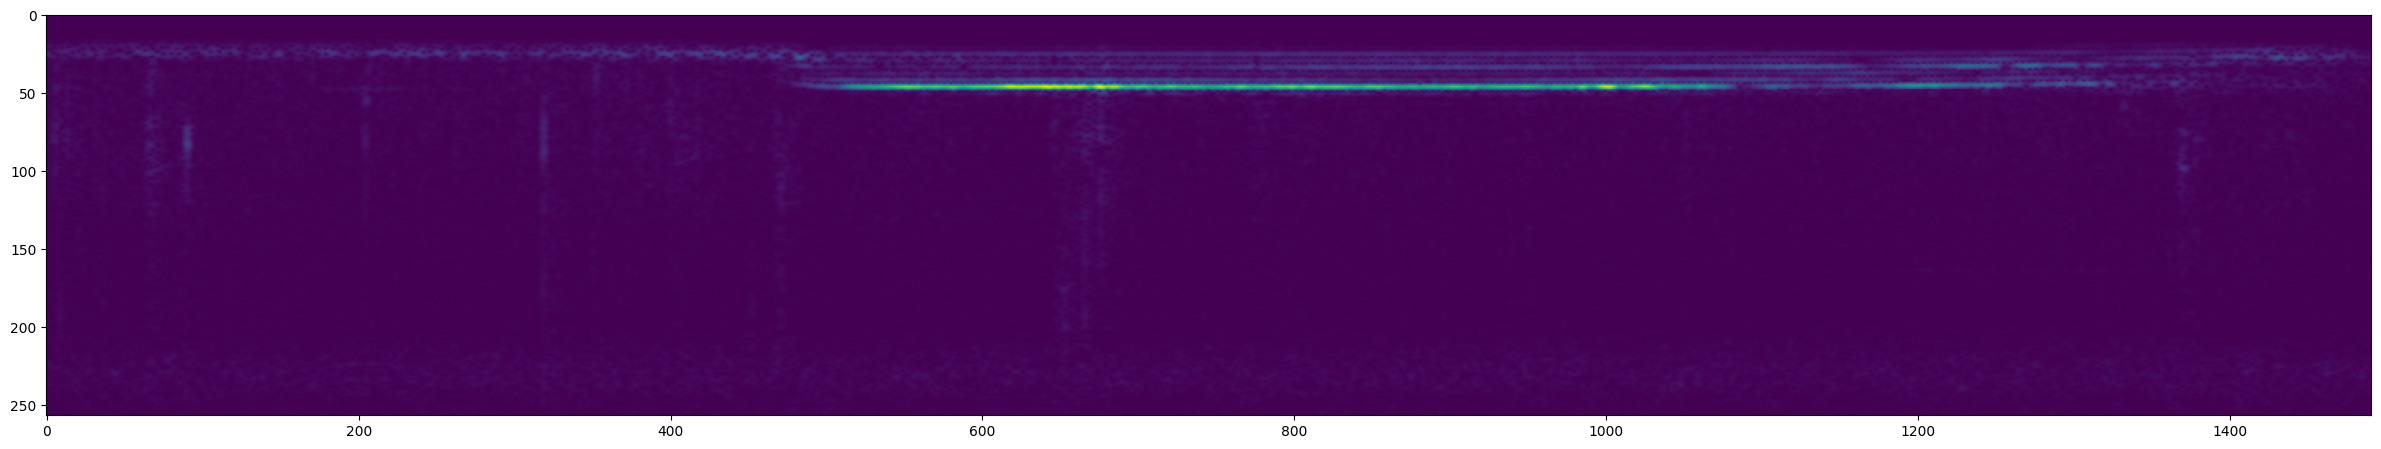

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [23]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [24]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [25]:
samples, labels = train.as_numpy_iterator().next()

In [26]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D


## 7.2 Build Sequential Model, Compile and View Summary

In [28]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=samples.shape[1:]),
    MaxPooling2D(),

    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 744, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 742, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 371, 62, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,785 (18.69 KB)

 Trainable params: 4,785 (18.69 KB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [31]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - loss: 0.6754 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6156 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - loss: 0.5807 - precision: 0.1351 - recall: 9.1430e-04 - val_loss: 0.4813 - val_precision: 1.0000 - val_recall: 0.0893
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - loss: 0.5089 - precision: 0.8897 - recall: 0.2404 - val_loss: 0.5039 - val_precision: 0.8684 - val_recall: 0.4521
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - loss: 0.4402 - precision: 0.8011 - recall: 0.4580 - val_loss: 0.3728 - val_precision: 1.0000 - val_recall: 0.4355


In [35]:
model.save('/content/model.keras')

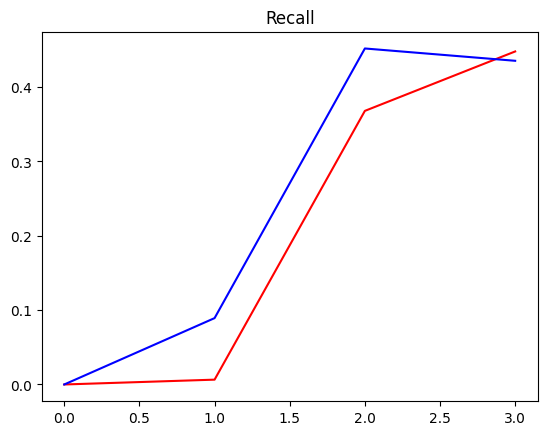

In [53]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

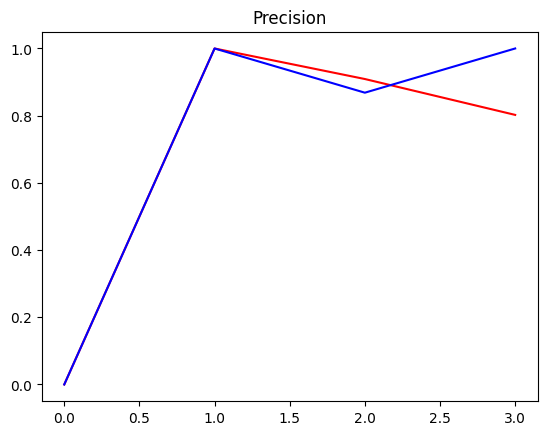

In [54]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [56]:
X_test, y_test = test.as_numpy_iterator().next()

In [57]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## 8.2 Convert Logits to Classes

In [58]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [59]:
import librosa

def load_mp3_16k_mono(filename):
    audio_data, sample_rate = librosa.load(filename, sr=16000, mono=True)
    wav = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    return wav

In [60]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [61]:
wav = load_mp3_16k_mono(mp3)

In [62]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [63]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [64]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [65]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [66]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step


## 9.4 Group Consecutive Detections

In [67]:
from itertools import groupby

In [68]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [69]:
calls

np.int32(0)

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [70]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5

In [71]:
results

{'recording_00.mp3': array([[0.06123376],
        [0.06633519],
        [0.06804096],
        [0.12006216],
        [0.7350358 ],
        [0.09541751],
        [0.06928436],
        [0.06700088],
        [0.06925697],
        [0.0626639 ],
        [0.06514671],
        [0.06656076],
        [0.06644338],
        [0.18082152],
        [0.7146757 ],
        [0.06901545],
        [0.08312778],
        [0.06574894],
        [0.06276217],
        [0.06519853],
        [0.06524534],
        [0.06581954],
        [0.06341177],
        [0.10033833],
        [0.73127073],
        [0.10342801],
        [0.07199804],
        [0.06403958],
        [0.0703373 ],
        [0.06615438],
        [0.06459826],
        [0.06411947],
        [0.07796654],
        [0.07809625],
        [0.06196974],
        [0.0869825 ],
        [0.7151221 ],
        [0.12102811],
        [0.0671633 ],
        [0.06274965],
        [0.06617151],
        [0.06889141],
        [0.06646121],
        [0.06966164],
        [0.0

## 10.2 Convert Predictions into Classes

In [72]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [73]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': np.int32(5),
 'recording_01.mp3': np.int32(0),
 'recording_02.mp3': np.int32(13),
 'recording_03.mp3': np.int32(8),
 'recording_04.mp3': np.int32(4),
 'recording_05.mp3': np.int32(0),
 'recording_06.mp3': np.int32(4),
 'recording_07.mp3': np.int32(2),
 'recording_08.mp3': np.int32(17),
 'recording_09.mp3': np.int32(0),
 'recording_10.mp3': np.int32(5),
 'recording_11.mp3': np.int32(2),
 'recording_12.mp3': np.int32(5),
 'recording_14.mp3': np.int32(2),
 'recording_13.mp3': np.int32(0),
 'recording_15.mp3': np.int32(2),
 'recording_16.mp3': np.int32(1),
 'recording_17.mp3': np.int32(3),
 'recording_19.mp3': np.int32(0),
 'recording_18.mp3': np.int32(0),
 'recording_20.mp3': np.int32(4),
 'recording_21.mp3': np.int32(1),
 'recording_22.mp3': np.int32(2),
 'recording_23.mp3': np.int32(0),
 'recording_25.mp3': np.int32(0),
 'recording_27.mp3': np.int32(0),
 'recording_24.mp3': np.int32(1),
 'recording_26.mp3': np.int32(1),
 'recording_29.mp3': np.int32(3),
 'recording_

# 11. Export Results

In [74]:
import csv

In [75]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [76]:
!ls

data  results.csv


In [77]:
import pandas as pd
pd.read_csv('results.csv').head(10)

,recording,capuchin_calls
0,recording_00.mp3,5
1,recording_01.mp3,0
2,recording_02.mp3,13
3,recording_03.mp3,8
4,recording_04.mp3,4
5,recording_05.mp3,0
6,recording_06.mp3,4
7,recording_07.mp3,2
8,recording_08.mp3,17
9,recording_09.mp3,0


In [78]:
from google.colab import files
files.download('results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>